In [2]:
import random
import numpy as np
from PIL import Image
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

!pip install torchsummary
from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

# This line detects if we have a gpu support on our system
device = ("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


### Define our network class

In [29]:

class ShallowNN4Images(nn.Module):
    def __init__(self, input_num, hidden_num, output_num):
        super(ShallowNN4Images, self).__init__()
        # we need to make a vector of input neurons from the image pixels
        self.flatten = nn.Flatten()
        hidden_num2 = (int)(hidden_num/2)
        self.hidden1 = nn.Linear(input_num, hidden_num) # hidden layer
        self.hidden2 = nn.Linear(hidden_num, hidden_num2) # hidden layer
        self.output = nn.Linear(hidden_num2, output_num) # output layer
        #self.sigmoid = nn.Sigmoid() # sigmoid activation function
        self.relu = nn.ReLU() # relu activation function
    
    def forward(self, x):
        x = self.flatten(x)
        # first hidden layer
        x = self.hidden1(x)
        #activation function
        x = self.relu(x) 
        #second hidden layer
        x = self.hidden2(x)
        #activation function
        x = self.relu(x) 
        #output layer
        out = self.output(x)
        return out

input_num = 100 # 10x10 image
hidden_num = 64
output_num = 10 # The output should be the same as the number of classes

model = ShallowNN4Images(input_num, hidden_num, output_num)
model.to(device) # send our model to gpu if available else cpu. 
#print(model)
print (summary(model, (1, 10, 10)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 100]               0
            Linear-2                   [-1, 64]           6,464
              ReLU-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
              ReLU-5                   [-1, 32]               0
            Linear-6                   [-1, 10]             330
Total params: 8,874
Trainable params: 8,874
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
None


### Define the Loss function

In [30]:
'''
Important Note: Pytorch does not need the network to have the last layer 
 - as a sigmoid layer for BCEWithLogitsLoss (it's computed inside the loss function)
 - as a softmax layer for CrossEntropyLoss (it's computed inside the loss function) 
'''

#binary classification
criterion_binary_case = torch.nn.BCEWithLogitsLoss()
#multi-class classification
criterion_multi_class = torch.nn.CrossEntropyLoss()


### Define your train val test dataset
#### Option 1: dataset is a part of pytorch
 

In [31]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler  #for validation test

#Define a transform to convert to images to tensor and normalize
transform = transforms.Compose([transforms.Resize(size=(10,10)),transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)]) #mean and std have to be sequences (e.g., tuples), 
                                                                      # therefore we should add a comma after the values

#transform for train also includes augmentation now!
#,transforms.RandomRotation(degrees=(0, 180)),
transform_train = transforms.Compose([transforms.Resize(size=(10,10)),transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)])                      
#Load the data: train and test sets
trainset = datasets.FashionMNIST('~/F_MNIST_data', download=True, train=True, transform=transform_train)
validset = datasets.FashionMNIST('~/F_MNIST_data1', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/F_MNIST_data', download=True, train=False, transform=transform)

#Preparing the validation test
indices = list(range(len(trainset)))
np.random.shuffle(indices)
#to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
print(len(indices[split:]))
train_sample = SubsetRandomSampler(indices[split:])
valid_sample = SubsetRandomSampler(indices[:split])

#Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=16)
validloader = torch.utils.data.DataLoader(validset, sampler=valid_sample, batch_size=16)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)




48000


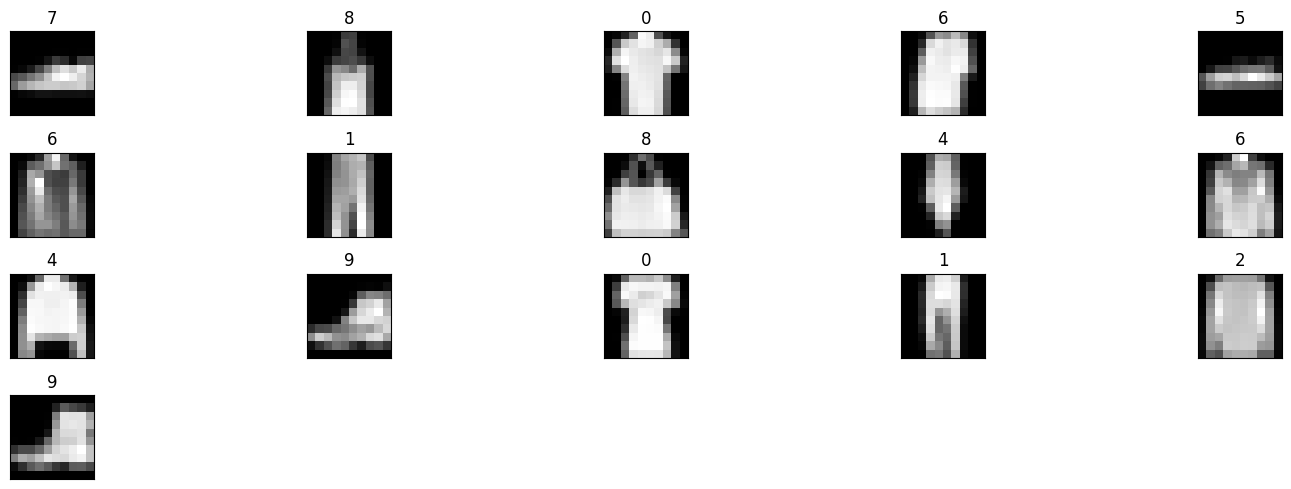

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(trainloader)
print(dataiter)
images, labels = next(dataiter)


fig = plt.figure(figsize=(15,5))
for idx in np.arange(16):
  # xticks=[], yticks=[] is empty to print the images without any ticks around them
  #np.sqeeze : Remove single-dimensional entries from the shape of an array.
  ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
   # .item() gets the value contained in a Tensor
  ax.set_title(labels[idx].item())
  fig.tight_layout()

#### Option 2: A CustomDatasetClass is defined

In [19]:
#fashion mnist dataset is also available in csv format
import pandas as pd
train_csv = pd.read_csv("~/F_MNIST_data/FashionMNIST/csv/fashion-mnist_train.csv")
test_csv = pd.read_csv("~/F_MNIST_data/FashionMNIST/csv/fashion-mnist_test.csv")

print (len(train_csv), len(test_csv))

class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        label = []
        image = []
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,),)]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,),)]))

train_dataset, valid_dataset = torch.utils.data.random_split(train_set, (50000, 10000))

print (len(train_dataset), len(valid_dataset), len(test_set))

60000 10000
50000 10000 10000


In [23]:
 #  defining accuracy function
def accuracy(network, dataloader):
      network.eval()
      total_correct = 0
      total_instances = 0
      for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        predictions = torch.argmax(network(images), dim=1)
        correct_predictions = sum(predictions==labels).item()
        total_correct+=correct_predictions
        total_instances+=len(images)
      return round(total_correct/total_instances, 3)

In [35]:
!pip install tensorboard
from torch.autograd import Variable
from tqdm import tqdm
import os
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(model)

start_epoch = 0
epochs = 1

####
#  creating log
log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': [],
        'training_accuracy_per_epoch': [],
        'validation_accuracy_per_epoch': []
    } 


for epoch in range(epochs):
      print(f'Epoch {epoch+1}/{epochs}')
      train_losses = []

      #  training
      print('training...')
      model.train()
      for images, labels in tqdm(trainloader):
        #  sending data to device
        images, labels = images.to(device), labels.to(device)
        #  resetting gradients
        optimizer.zero_grad()
        #  making predictions
        predictions = model(images)
        #  computing loss
        loss = criterion_multi_class(predictions, labels)
        log_dict['training_loss_per_batch'].append(loss.item())
        train_losses.append(loss.item())
        #  computing gradients
        loss.backward()
        #  updating weights
        optimizer.step()
      with torch.no_grad():
        print('deriving training accuracy...')
        #  computing training accuracy
        train_accuracy = accuracy(model, trainloader)
        log_dict['training_accuracy_per_epoch'].append(train_accuracy)

      #  validation
      print('validating...')
      val_losses = []

      #  setting convnet to evaluation mode
      model.eval()

      with torch.no_grad():
        for images, labels in tqdm(validloader):
          #  sending data to device
          images, labels = images.to(device), labels.to(device)
          #  making predictions
          predictions = model(images)
          #  computing loss
          val_loss = criterion_multi_class(predictions, labels)
          log_dict['validation_loss_per_batch'].append(val_loss.item())
          val_losses.append(val_loss.item())
        #  computing accuracy
        print('deriving validation accuracy...')
        val_accuracy = accuracy(model, validloader)
        log_dict['validation_accuracy_per_epoch'].append(val_accuracy)

      train_losses = np.array(train_losses).mean()
      writer.add_scalar("Loss/train", train_losses, epoch)
      val_losses = np.array(val_losses).mean()

      print(f'training_loss: {round(train_losses, 4)}  training_accuracy: '+
      f'{train_accuracy}  validation_loss: {round(val_losses, 4)} '+  
      f'validation_accuracy: {val_accuracy}\n')
      
####
#  saving model
# Get the current datetime
current_datetime = datetime.now()

# Convert the datetime to a string
datetime_string = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

print(datetime_string)

torch.save(model.state_dict(), 'model_Shallow_FMNIST'+datetime_string+'.pth')
print('model saved')
writer.close()

ShallowNN4Images(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden1): Linear(in_features=100, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
)
Epoch 1/1
training...


100%|██████████| 3000/3000 [00:19<00:00, 157.60it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:15<00:00, 195.14it/s]


validating...


100%|██████████| 750/750 [00:03<00:00, 202.16it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:03<00:00, 187.97it/s]

training_loss: 0.5686  training_accuracy: 0.797  validation_loss: 0.5759 validation_accuracy: 0.794

2024-04-01_16-56-19
model saved


### Simple convolutional neural network

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x

cnn_model= SimpleCNN()
cnn_model.to(device)
summary(cnn_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25